In [11]:
# Python IMPORTS
import numpy as np
import scipy as sp
import scipy.integrate
import seaborn as sns
import copy

def ndstr(a, format_string ='{0:.3f}'):
    return [format_string.format(v,i) for i,v in enumerate(a)]

from JSAnimation import IPython_display
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  



In [2]:
# The physics engine

# ODES   - Ordinary Differential Equations

# t - time [s]
# X = [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z]  [m, m/s]
# forceVector - [force_x, force_y, force_z]       [N]
# dampeningFactor - dampening of force based on velocity
# links - Link class objects
# particle - this mass particle and metadata
#
def newtonEq(t, X, mass, forceVector, dampeningFactor, particle):
    X_prime = np.zeros(len(X));
    # position
    X_prime[0] = X[3];
    X_prime[1] = X[4];
    X_prime[2] = X[5];
    
    # velocity
    springforce = np.zeros(3);
    for link in particle.links:
        springforce += link.getForce(particle);
    X_prime[3] = ((particle.force[0] + springforce[0]) - dampeningFactor*X[3])/mass;   # model adds velocity dampening in place
    X_prime[4] = ((particle.force[1] + springforce[1]) - dampeningFactor*X[4])/mass;   # of internal friction
    X_prime[5] = ((particle.force[2] + springforce[2]) - dampeningFactor*X[5])/mass + -9.81;  # add gravity
    return X_prime;

# wrapper for numerical intergration
def integrate(t, dt, particle, numSteps=20):  
    method = sp.integrate.ode(newtonEq).set_integrator('dopri5', nsteps=numSteps);  # runge-katta 4-5 method
    method.set_initial_value(particle.posvel, t).set_f_params( particle.mass, particle.force, particle.dampeningFactor, particle);
    return method.integrate(method.t+dt);

In [3]:
# mesh class design influenced by https://github.com/valorcurse/cloth-simulation
#  WTFPL license - http://www.wtfpl.net/

# data structure to model the FABRIC

class Particle:
    def __init__(self, posvel, mass, dampeningFactor):
        self.posvel = posvel   # position, velocity [x,y,z x_dot, y_dot, z_dot]
        self.lastPosvel = posvel
        self.mass = mass
        self.dampeningFactor = dampeningFactor;
        self.force =  np.zeros(3);
        self.anchored = False
        self.links = []
    
    def update(self, et, dt):
        if(not self.anchored):
            self.posvel = integrate(et, dt, self);
        
    def applyForce(self, vec3d):
        self.force = vec3d;
        
    def applyConstraints(self, circleCenters, circleRadius):
        # body collision
        #    if collided, move to surface and zero out velocity normal to that move
        #    check the full set of circles
        for i in range(len(circleRadius)):
            center = circleCenters[i]
            relLoc = np.array(((self.posvel[0]-center[0]), (self.posvel[1]-center[1]),(self.posvel[2]-center[2])))
            dist = np.linalg.norm(relLoc)
            if dist < circleRadius[i]:
                # we have collided and are currently inside the circle
                # move to surface along relative position vector
                self.posvel[:3] = center + relLoc * circleRadius[i] / dist
                # reset velocity, zeroing component in relative position direction
                self.posvel[3:] = np.cross(self.posvel[3:], relLoc / dist)
                
        
        for link in self.links:
            link.applyConstraints()
        
class Link:
    def __init__(self, part1, part2, restingDist, k):
        self.particle1 = part1
        self.particle2 = part2
        self.restingDistance = restingDist
        self.springConstant = k
        
    def getForce(self, particle):
        # direction is with respect to particle in the argument
        #   spring force is always directed along the length of the spring
        #   either towards or away from the center
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
    
        # displacement in 1D
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        currLen = np.sqrt(dx * dx + dy * dy + dz * dz);
        # spring force
        mag_force = self.springConstant * (currLen - self.restingDistance);    # hooke's law F = kx
        
        # place force in the direction of the spring
        springForce =  np.zeros(3);
        if(currLen > 0):
            # being length 0 should be vanishingly rare chance, so we'll just skip it for a step
            springForce[0] = (dx/currLen) * mag_force;
            springForce[1] = (dy/currLen) * mag_force;
            springForce[2] = (dz/currLen) * mag_force;
        
        return springForce
    
    def getLen(self, particle):
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
        
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        return np.sqrt(dx * dx + dy * dy + dz * dz);
    
    def getDir(self, particle):
        if(particle == self.particle1):
            part1 = self.particle1;
            part2 = self.particle2;
        elif(particle == self.particle2):
            part2 = self.particle1;
            part1 = self.particle2;
        else:
            raise ValueError('a bad thing happened, the specified particle to use as reference location is not in this Link')
        
        dz = part2.posvel[2] - part1.posvel[2];
        dy = part2.posvel[1] - part1.posvel[1];
        dx = part2.posvel[0] - part1.posvel[0];
        mag = np.sqrt(dx * dx + dy * dy + dz * dz);
        dirVec = np.zeros(3);
        dirVec[0] = dx/mag;
        dirVec[1] = dy/mag;
        dirVec[2] = dz/mag;
        return dirVec;
        
    
    def applyConstraints(self):
        # do nothing for now, we only constrain points not edges
        pass





In [7]:
# build a test of our cloth model

squareSize = 0.1;
width = 8;  # points
height = 9; # points

k = 100;
mass = .197*squareSize*squareSize;  # 197 g/ m^2
dampening = 0.005;

points = [Particle(np.array((0.0, 0.0, 0.0, 0.0, 0.0, 0.0)), mass, dampening) for x in xrange(width*height)]
for point in range(0, len(points)):
    points[point].posvel[1] = (point % width) * squareSize;  
    points[point].posvel[0] = np.floor(point / width) * squareSize;
    
    # Link to point to the right (rows)
    if ((point+1) <= len(points) and (point+1) % width != 0):
        points[point].links.append(Link(points[point], points[(point+1)], squareSize, k))

    # Link to point above (columns)
    if ((point+width) < len(points)):
        points[point].links.append(Link(points[point], points[point+width], squareSize, k))
        
    # Link to point to the left (rows)
    if ((point) > 0 and point % width != 0):
        points[point].links.append(Link(points[point], points[(point-1)], squareSize, k))

    # Link to point below (columns)
    if ((point-width) >= 0):
        points[point].links.append(Link(points[point], points[point-width], squareSize, k))

# Pin the top two points
points[0].anchored = True
points[width-1].anchored = True

In [13]:
import itertools

def getAngle(particle1, originParticle, particle2):
    # calculate the angle between two particles with a third at the origin
    v1 = particle1.posvel[:3]-originParticle.posvel[:3]   # vector 1
    v2 = particle2.posvel[:3]-originParticle.posvel[:3]   # vector 2
    
    angle = np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
    if np.isnan(angle):
        if (v1 / np.linalg.norm(v1) == v2 / np.linalg.norm(v2)).all():
            return 0.0
        else:
            return np.pi
    return angle

def utility(points):
    # calculate the utility
    tension = 0
    angles = 0
    for point in points:
        numLinks = len(point.links)
        maxAngle = 0;
        for pair in itertools.product(range(numLinks), repeat=2):
            idx0 = pair[0]
            idx1 = pair[1]
            maxAngle = np.maximum(maxAngle, getAngle(point.links[idx0].particle2, point.links[idx0].particle1, point.links[idx1].particle2))
        angles += np.pi - maxAngle
        for link in point.links:
            tension += np.linalg.norm(link.getForce(link.particle2))
    
    return tension + angles

def cooling(T):
    return T * 0.8

def acceptanceP(curUtil, newUtil, T):
    if newUtil >= curUtil:
        return 1;
    else:
        return np.exp(-(newUtil - curUtil)/T)

def sa(k, density, dampening, points):
    # simulated annealing function, returns the best model
    T_0 = 100;
    
    # initial state generation
    # a 1D adjustment to the anchor position, positive moves left and right anchors outward by that amount
    dAnchor = 0
    
    points0 = copy.deepcopy(points)
    oldEnergy = utility(points0) 
    
    T = T_0
    while T > 1:        
        points0 = copy.deepcopy(points)
        dAnchor_proposal = np.random.randn(1)*(0.01*T) + dAnchor
        points0[0].posvel[0] = points[0].posvel[0] - dAnchor_proposal
        points0[width-1].posvel[0] = points[width-1].posvel[0] + dAnchor_proposal
        
        energy = utility(points0)                 
        if acceptanceP(oldEnergy, energy, T) > np.random.rand(1):
            # accept the proposed state
            dAnchor = dAnchor_proposal
            oldEnergy = energy
        
        # anneal, drop the temperature
        T = cooling(T)

    return (dAnchor)


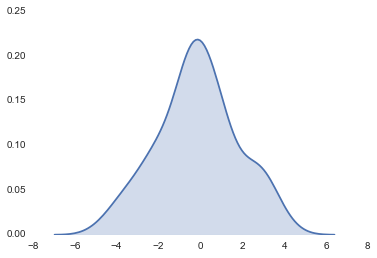

In [14]:

# Monte Carlo Loop
N = 100;

anchorDist_hist = np.zeros((N))   # history over the monte carlo

dampening = 0.005;

for i in range(N):
    mass = np.random.randn(1)*0.1 + 0.197
    k = np.random.randn(1)*10 + 100
    results = sa(k, mass, dampening, points)
    anchorDist_hist[i] = results

# look at the histogram of position
plt.figure()
sns.kdeplot(anchorDist_hist, shade=True)
plt.show()

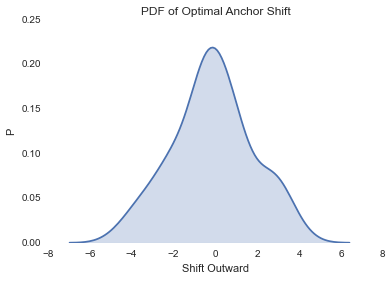

In [15]:
# look at the histogram of position
plt.figure()
sns.kdeplot(anchorDist_hist, shade=True)
plt.xlabel('Shift Outward')
plt.ylabel('P')
plt.title('PDF of Optimal Anchor Shift')
plt.show()

In [6]:
def plotPoints(points):
    xs = np.zeros(len(points));
    ys = np.zeros(len(points));
    zs = np.zeros(len(points));
    for pointIdx in range(len(points)):
        xs[pointIdx] = points[pointIdx].posvel[0]
        ys[pointIdx] = points[pointIdx].posvel[1]
        zs[pointIdx] = points[pointIdx].posvel[2]
    plot = ax.scatter(xs, ys, zs, s=16)
    #for link in point.links:
    #    plot = ax.plot([link.particle1.posvel[0], link.particle2.posvel[0]], [link.particle1.posvel[1], 
    #                    link.particle2.posvel[1]], [link.particle1.posvel[2], link.particle2.posvel[2]])   
    return plot

In [ ]:

# re-run with mean-likely optimal

# TODO extract the mean likely dAnchor from the anchorDist_hist variable
dAnchor_meanLikelyOptimal = ;

simtime = 0;
timestep = 0.0001;
endtime = 3;

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotPoints(points)
plt.title('Initial (t = 0 s)')
plt.show()

counter = 0;
savePointIdx = 0;
its = 500;
savePoints = int((endtime - simtime) / timestep / its);
xs = np.zeros((savePoints, len(points)));
ys = np.zeros((savePoints, len(points)));
zs = np.zeros((savePoints, len(points)));
timeHist =  np.zeros(savePoints);

points0 = copy.deepcopy(points)
points0[0].posvel[0] -= dAnchor_meanLikelyOptimal
points0[width-1].posvel[0] += dAnchor_meanLikelyOptimal

while simtime < endtime:
    for point in points0:
        point.applyConstraints();

    for point in points0:
        point.update(simtime, timestep);
    simtime = simtime + timestep;
    counter = counter + 1;
    
    if(counter % its == 0):
        timeHist[savePointIdx] = simtime;
        for pointIdx in range(len(points)):
            xs[savePointIdx, pointIdx] = points[pointIdx].posvel[0]
            ys[savePointIdx, pointIdx] = points[pointIdx].posvel[1]
            zs[savePointIdx, pointIdx] = points[pointIdx].posvel[2]
        savePointIdx = savePointIdx + 1;

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

numframes = 60
numPoints = 120;
#data = np.random.rand(numframes, numPoints, 3)  # a (time, position) array
data = np.zeros((numframes, numPoints, 3))
print data.shape
data[:,:,0] = xs;
data[:,:,1] = ys;
data[:,:,2] = zs;

ix = data[0,:,0]
iy = data[0,:,1]
iz = data[0,:,2]
#print ix
sc = ax.scatter(ix, iy, iz, c='k')
ax.set_xlim3d(-1.2,1.2)
ax.set_ylim3d(-0.2,1.2)
ax.set_zlim3d(-1.2,0.2)

def animate(i, data_x, data_y, data_z, sc):
    #print len(data[i,:,0])
    
    # this works
    #sc._offsets3d = (data_x[i,:], data_y[i,:], data_z[i,:])
    
    # so does this
    ax.clear()
    sc = ax.scatter(data_x[i,:], data_y[i,:], data_z[i,:], c='k')
    ax.set_xlim3d(-1.2,1.2)
    ax.set_ylim3d(-0.2,1.2)
    ax.set_zlim3d(-1.2,0.2)
    return sc,

animation.FuncAnimation(fig, animate,  frames=numframes, interval=100, blit=False, fargs=(data[:,:,0], data[:,:,1], data[:,:,2],sc)